In [1]:
import pandas as pd
import numpy as np, scipy.stats as st
from datetime import datetime
import statsmodels.stats.api as sms
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.formula.api as smf 
import requests 
from urllib.parse import urlencode 
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

***

## Проект: вариант 1

***
**Задание 1**
 * Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared
 * *shared/problem1-reg_data.csv* – данные о времени регистрации
 * *shared/problem1-auth_data.csv* – данные о времени захода пользователей в игру

Создадим две переменные, в каждой будет храниться ссылка на путь к соответствующему файлу

In [2]:
# ссылка на путь к данным о регистрации

path_reg = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-aljapin-31/shared/problem1-reg_data.csv' 

In [3]:
# ссылка на путь к данным о времени захода пользователей в игру

path_auth = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-aljapin-31/shared/problem1-auth_data.csv'

Прочитаем данные и проведем предварительный анализ

In [4]:
reg = pd.read_csv(path_reg, sep=';') # Датафрейм с данными о регистрации

In [5]:
reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [6]:
reg.dtypes

reg_ts    int64
uid       int64
dtype: object

Даты регистрации записаны в Unix timestamp, нужно будет перевести в текущие даты

In [7]:
reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

Пропусков не обнаружено

In [8]:
reg.shape

(1000000, 2)

In [9]:
reg.uid.nunique()

1000000

Количество уникальных пользователей совпадает с количеством строк в датафрейме, повторов нет

Преобразуем дату регистрации в формат datetime

In [10]:
reg.reg_ts = pd.to_datetime(reg.reg_ts, unit='s')

In [11]:
reg.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [12]:
reg.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

Самая ранняя дата регистрации

In [13]:
reg.reg_ts.min()

Timestamp('1998-11-18 09:43:43')

Последняя дата регистрации

In [14]:
reg.reg_ts.max()

Timestamp('2020-09-23 15:17:24')

Посмотрим количество пользователей по годам регистрации

In [15]:
reg['years'] = reg.reg_ts.dt.year

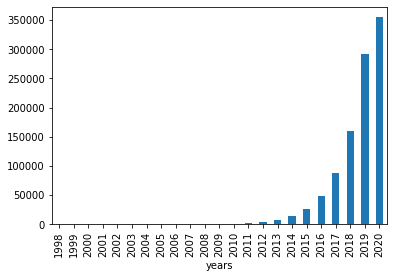

In [16]:
reg.groupby('years')['uid'].nunique().plot(kind='bar')

In [17]:
reg.groupby('years')['uid'].nunique()

years
1998         1
1999         1
2000         4
2001         6
2002        10
2003        20
2004        35
2005        65
2006       119
2007       216
2008       394
2009       718
2010      1308
2011      2385
2012      4361
2013      7932
2014     14455
2015     26344
2016     48187
2017     87645
2018    159729
2019    291102
2020    354963
Name: uid, dtype: int64

Большинство зарегистрированных пользователей в диапазоне с 2016 по 2020 год

Проанализируем данные о времени захода пользователей в игру

In [18]:
auth = pd.read_csv(path_auth, sep = ';')

In [19]:
auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Аналогично, потребуется преобразование даты из unix timestamp в datetime

In [20]:
auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [21]:
auth.dtypes

auth_ts    int64
uid        int64
dtype: object

Пропусков нет

In [22]:
auth.shape # Размер датафрейма

(9601013, 2)

***

## Напишем функцию retention для прослеживания данамики пользования приложением

***

Для написания данной функции следует учесть следующие аспекты:

1. Скорее всего потребуется использовать данную функцию в диапазоне интересующих дат с указанием времени наблюдения   
retention (количества дней);
   
2. Следует учесть возможность изменения пути к файлам;
3. Показатель retention необходимо вывести по дням от даты регистрации игрока;
4. В случае отсутствия ввода аргументов вывести retention по всем данным.

Прежде чем написать функцию retention, следует заранее учитывать время на ее выполнение.
Сделаем удобной функцию для ее пользователей и для этого напишем вспомогательную функцию для получения общего датафрейма.
Т.к. функцию retention понадобится выполнять в различных временных срезах, будем применять к уже считанному датафрейму, тем самым снизим время на ее выполнение.

Функция получения обработанного датафрейма

In [69]:
def get_df(path_reg=None, path_auth=None):
    """
    Параметры:
    
    path_reg: str, по умолчанию None
        - path_reg = None: Чтение и запись в датафрейм данных о зарегистрированных пользователей используя вариант 
        стандартного пути к файлу;
          Warning: Предупреждеждение о необходимости указать другой путь к файлу в параметре path_reg;
         
    path_auth: str, по умолчанию None
        -  path_auth = None: Чтение и запись в датафрейм данных о времени захода пользователей  в игру используя вариант 
        стандартного пути к файлу;
          Warning: Предупреждеждение о необходимости указать другой путь к файлу в параметре path_auth;
    """
    # Чтение данных и запись в датафреймы при стандартном пути к файлам и заданном пути:
    
    if path_reg is None:
        try:
            path_reg = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-aljapin-31/shared/problem1-reg_data.csv'
            reg = pd.read_csv(path_reg, sep=';') # Чтение файла с данными по зарегистрированным пользоватеям
        except: 
            print("Чтение файла 'problem1-reg_data.csv' не удалось, укажите другой путь в аргументе path_auth")
    else:
        reg = pd.read_csv(path_reg, sep=';')
    if path_auth is None:
        try:
            path_auth = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-aljapin-31/shared/problem1-auth_data.csv'
            auth = pd.read_csv(path_auth, sep = ';') #  Чтение файла с данными с временем захода в игру
        except: 
            print("Чтение файла 'problem1-auth_data.csv' не удалось,  укажите другой путь в аргументе path_reg")
    else:
        auth = pd.read_csv(path_auth, sep = ';')
        
    reg.reg_ts = pd.to_datetime(reg.reg_ts, unit='s') # Перевод времени регистрации из unix timestamp в datetime
    reg.reg_ts = reg.reg_ts.dt.date # Оставляем только дату
    
    # Соединяем два датафрейма по ID пользователей:
    users = reg.merge(auth, on = 'uid', how = 'inner')
    users.auth_ts = pd.to_datetime(users.auth_ts, unit='s') # Перевод времени захода из unix timestamp в datetime
    users.auth_ts =  users.auth_ts.dt.date # Оставляем только дату
    return users

Функция retention

In [24]:
def retention(users, start=None, end=None, days = None):
    """
    Параметры:
    
    users: DataFrame, таблица по которой необходимо рассчитать retention;
    
    start: str, по умолчанию None - начальная дата заданного диапазона, 
            если параметр не указывается, берется самая ранняя дата в таблице;
            
    end: str, по умолчанию None - конечная дата заданного диапазона, 
            если параметр не указывается, берется самая последняя дата в таблице;
            
    Если оба параметра не указаны, расчет производится по всему датафрейму.   
    
    days: int, по умолчанию None - количество дней по которым будет производится расчет;
            если параметр не указывается, расчет производится по всем доступным дням для когорты.
    
    """
    
    # Заданные временные границы для зарегистрированных пользователей и фильтрация датафрейма:
    
    if (start is not None) and (end is not None):
        users = users[(users['reg_ts'] >= pd.to_datetime(start)) & (users['reg_ts'] <= pd.to_datetime(end))]

    if (start is not None) and (end is None):
        users = users[users['reg_ts'] >= pd.to_datetime(start)]

    if (start is None) and (end is not None):
        users = users[users['reg_ts'] <= pd.to_datetime(end)]
         
    # Считаем количество уникальных пользователей по датам регистрации и записываем в датафрейм
    users_reg = users.groupby('reg_ts', as_index=False).agg({'uid':'nunique'}).rename(columns={'uid':'users_reg'})
    
    # Группируем по времени регистрации и дате захода и считаем количество уникальных пользователей
    users_by_day = users.groupby(['reg_ts','auth_ts'], as_index=False).agg({'uid':'nunique'})\
                                                                        .rename(columns={'uid':'users_by_day'})
    
    # Соединяем два датафрейма в один:
    users_retantion = users_reg.merge(users_by_day, on='reg_ts', how='left')
    
    # Считаем разницу в днях между датой регистрации и датой захода
    users_retantion['delta_days'] = users_retantion.auth_ts - users_retantion.reg_ts
    
    # Оставляем только количество дней
    users_retantion['delta_days'] = users_retantion['delta_days'].dt.days
    
    # Фильтруем датафрейм по указанному количеству дней в параметре
    if days is not None:
        d = days
        users_retantion = users_retantion.query('delta_days <= @d')
            
    # Считаем retention
    users_retantion['retantion'] = users_retantion.users_by_day / users_retantion.users_reg
    
    # Транспонируем таблицу по датам захода с помошью pivot
    retantion_tabl = users_retantion.pivot(index='reg_ts', columns = 'delta_days', values = 'retantion')
    
    # Форматируем таблицу: переводим показатель в %, красим ячейки в зависимости от уровня показателя, избавляемся от NaN,
    ur_style = (retantion_tabl
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
    return ur_style

Выполним функцию получения готового датафрейма для расчета

In [25]:
df = get_df()

In [26]:
df

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05
...,...,...,...
9601008,2020-09-23,1110618,2020-09-23
9601009,2020-09-23,1110619,2020-09-23
9601010,2020-09-23,1110620,2020-09-23
9601011,2020-09-23,1110621,2020-09-23


Функция retention за период с 2020-09-01 по 2020-09-15, расчет за 15 дней

In [27]:
retention(df, start='2020-09-01', end='2020-09-15', days=15)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


delta_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
reg_ts,,,,,,,,,,,,,,,,
2020-09-01,100.00%,2.02%,4.10%,4.22%,4.60%,6.43%,5.61%,6.43%,4.10%,5.42%,5.11%,5.36%,4.85%,5.49%,4.29%,4.41%
2020-09-02,100.00%,2.52%,3.90%,4.66%,5.67%,6.23%,7.12%,6.30%,4.85%,4.09%,5.67%,5.48%,5.48%,4.35%,4.97%,5.29%
2020-09-03,100.00%,2.33%,5.41%,4.71%,6.54%,6.98%,8.55%,6.35%,5.47%,6.29%,6.35%,5.53%,5.85%,5.97%,5.47%,5.34%
2020-09-04,100.00%,2.01%,3.64%,3.64%,5.15%,6.40%,7.28%,4.96%,5.34%,4.33%,5.65%,5.52%,4.33%,5.59%,4.39%,4.52%
2020-09-05,100.00%,2.76%,3.95%,4.64%,5.45%,5.89%,7.46%,4.89%,5.08%,5.45%,6.02%,5.20%,4.57%,5.39%,4.51%,5.14%
2020-09-06,100.00%,3.13%,4.32%,5.44%,5.63%,5.88%,6.82%,6.07%,5.82%,5.50%,4.88%,4.75%,5.38%,5.19%,5.50%,4.57%
2020-09-07,100.00%,2.94%,4.25%,5.37%,5.06%,6.37%,7.31%,5.25%,4.12%,5.62%,6.00%,5.68%,4.56%,5.06%,4.25%,5.06%
2020-09-08,100.00%,1.75%,3.93%,3.93%,4.86%,7.61%,7.54%,6.61%,5.17%,5.17%,6.55%,5.36%,5.92%,5.17%,4.74%,3.05%
2020-09-09,100.00%,1.74%,3.24%,4.67%,5.72%,6.66%,5.72%,5.91%,4.36%,5.04%,3.73%,5.04%,4.79%,4.85%,2.43%,


Функция retention с 2020-09-10 по конечную дату

In [28]:
retention(df, start='2020-09-10')

delta_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
reg_ts,,,,,,,,,,,,,,
2020-09-10,100.00%,2.05%,4.29%,4.79%,4.23%,6.77%,6.28%,7.09%,4.85%,4.54%,5.66%,4.72%,5.22%,3.60%
2020-09-11,100.00%,1.30%,4.03%,4.53%,5.65%,5.71%,6.70%,6.33%,4.40%,4.65%,5.40%,5.33%,3.29%,
2020-09-12,100.00%,1.92%,3.84%,4.71%,4.65%,6.07%,6.57%,5.76%,5.27%,5.14%,5.70%,2.54%,,
2020-09-13,100.00%,1.98%,4.08%,4.26%,5.13%,6.55%,6.49%,4.94%,4.70%,4.94%,3.58%,,,
2020-09-14,100.00%,2.22%,3.83%,4.51%,5.31%,6.49%,6.98%,6.30%,4.45%,2.90%,,,,
2020-09-15,100.00%,2.22%,4.07%,4.56%,6.04%,5.61%,6.90%,5.67%,2.46%,,,,,
2020-09-16,100.00%,1.91%,4.25%,4.62%,4.68%,6.77%,6.95%,3.38%,,,,,,
2020-09-17,100.00%,1.66%,4.30%,4.55%,5.47%,6.27%,4.24%,,,,,,,
2020-09-18,100.00%,1.90%,4.54%,4.23%,5.21%,3.74%,,,,,,,,


**Задание 2**

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Напишем функцию загрузки файла с данными с Яндекс-диска

In [29]:
# Функция для получения загрузочной ссылки с яндекс-диска:

def download_yandex(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

In [30]:
path = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' # Ссылка для скачивания

In [31]:
df = pd.read_csv(download_yandex(path), sep= ';') # Загружаем файл в датафрейм

In [32]:
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [33]:
df.dtypes # Проверяем типы данных

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [34]:
df.isna().sum() # Пропущенные значения

user_id      0
revenue      0
testgroup    0
dtype: int64

Количество уникальных пользователей в контрольной и тестовой группе совпадает с количеством строк в датафрейме, значит дублирования id пользователей нет

In [35]:
df.testgroup.value_counts().sum()

404770

In [36]:
df.shape[0]

404770

Посмотрим на количество платящих пользователей в группах

In [37]:
df.query('revenue > 0').testgroup.value_counts()

a    1928
b    1805
Name: testgroup, dtype: int64

Для удобства переименуем названия групп на контрольную и тестовую

In [38]:
df.testgroup = df.testgroup.apply(lambda x: 'control' if x =='a' else 'test')
df.head()

,user_id,revenue,testgroup
0,1,0,test
1,2,0,control
2,3,0,control
3,4,0,test
4,5,0,test


Добавим столбец для определения категории пользователей (платящие = 1, остальные =  0)

In [39]:

df['payment'] = df.revenue.apply(lambda x: 1 if x > 0 else 0)
    

Сгруппируем датафрейм и рассчитаем conversion rate и ARPU в разрезе каждой группы

In [40]:
groups = df.groupby('testgroup', as_index=False).agg({'payment': 'mean', 'revenue': 'mean'})\
    .rename(columns={'payment':'CR', 'revenue':'ARPU'})
groups

,testgroup,CR,ARPU
0,control,0.009540,25.413720
1,test,0.008906,26.751287


Рассчитаем выручку на каждую группу и количество платящих пользователей

In [41]:
groups_1 =  df.groupby('testgroup', as_index=False).agg({'revenue':'sum', 'payment':'sum'})\
    .rename(columns={'payment':'paying_users'})

Соединим 2 датафрейма

In [42]:
metrics = groups_1.merge(groups, on = 'testgroup')
metrics

,testgroup,revenue,paying_users,CR,ARPU
0,control,5136189,1928,0.009540,25.413720
1,test,5421603,1805,0.008906,26.751287


Рассчитаем ARPPU

Итоговая сводная таблица

In [43]:
metrics['ARPPU'] = metrics.revenue / metrics.paying_users
metrics

,testgroup,revenue,paying_users,CR,ARPU,ARPPU
0,control,5136189,1928,0.009540,25.413720,2663.998444
1,test,5421603,1805,0.008906,26.751287,3003.658172


In [44]:
print('Вывод по сводной таблице:')
print(f'Конверсия снизилась на {round((metrics.CR[0] / metrics.CR[1] - 1)*100, 2)} %')
print(f'Метрика ARPU увеличилась на {round((metrics.ARPU[1] / groups.ARPU[0] - 1)*100, 2)} %')
print(f'Метрика ARPPU увеличилась на {round((metrics.ARPPU[1] / metrics.ARPPU[0] - 1)*100, 2)} %')

Вывод по сводной таблице:
Конверсия снизилась на 7.11 %
Метрика ARPU увеличилась на 5.26 %
Метрика ARPPU увеличилась на 12.75 %


Как видим из вывода сводной таблицы, сумма на платящего пользователя в тестовой группе значительно увеличивается.
Целесообразно проверить изменение именно этой метрики. 
Т.к. конверсия низкая (менее 1%), большая часть позьзователей с нулевой стоимостью не представляет для нас значительного интереса в части сравнения стоимостных метрик.

Для определения лучшего набора акционных предложений проверим следующую гипотезу:   

H0 - ARPPU не различается в контрольной и тестовой группе;   
H1 - В тестовой группе метрика ARPPU выше контрольной группы, акционные предложения в тестовой группе лучше.

In [45]:
plt.style.use('ggplot')

Отфильтруем датафрейм и оставим только платящих пользователей

In [46]:
df_corr = df.query('revenue > 0')

In [47]:
df_corr

,user_id,revenue,testgroup,payment
72,73,351,control,1
160,161,3797,test,1
341,342,290,control,1
377,378,3768,test,1
385,386,250,control,1
...,...,...,...,...
404315,404316,262,control,1
404525,404526,3120,test,1
404543,404544,369,control,1
404602,404603,251,control,1


Отобразим на графике boxplot выручку и посмотрим на распределения

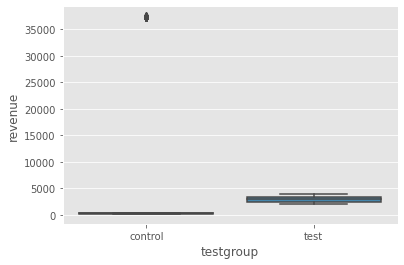

In [48]:
sns.boxplot(x = df_corr.testgroup, y = df_corr.revenue)

Как видим из графика, имеются значительные выбросы в контрольной группе   

Из таблицы описательных статистик данных групп видим, что медианы различаются в группах практичестки в 10 раз, при этом средние значения различаются не на порядок, за счет выбросов в контрольной группе.

In [49]:
df_corr.groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
control,1928.0,2663.998444,9049.039763,200.0,257.0,311.0,361.0,37433.0
test,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Будем считать, что в контрольную группу подгрузились топ-пользователи, которые совершали покупки на значительные суммы.


In [50]:
top_users = df_corr.query('revenue > 30000')
top_users

,user_id,revenue,testgroup,payment
416,417,37324,control,1
4428,4429,37304,control,1
5777,5778,37315,control,1
8065,8066,37307,control,1
8743,8744,37334,control,1
...,...,...,...,...
360696,360697,37347,control,1
378668,378669,37297,control,1
389341,389342,37298,control,1
394580,394581,37302,control,1


In [51]:
f"""Таких пользователей составляет \
{round(top_users.user_id.nunique() / df_corr.query('testgroup == "control"').user_id.nunique() * 100, 2)} % от контрольной группы,\
\
 Общая сумма на топ-пользователей {round(df_corr.query('revenue > 30000')['revenue'].sum() / metrics.revenue[0] * 100, 2)} % от контрольной\
"""

'Таких пользователей составляет 6.38 % от контрольной группы, Общая сумма на топ-пользователей 89.37 % от контрольной'

Ввиду значительного различия выручки на топ-пользователей и основной аудитории, отбросим топ-пользователей из контрольной группы 

In [52]:
df_corr_1 = df_corr.query('revenue < 30000')

Выборки в контрольной и тестовой группах одинаковые по размеру

In [53]:
df_corr_1.testgroup.value_counts()

control    1805
test       1805
Name: testgroup, dtype: int64

Отобразим на графике boxplot выручку по группам

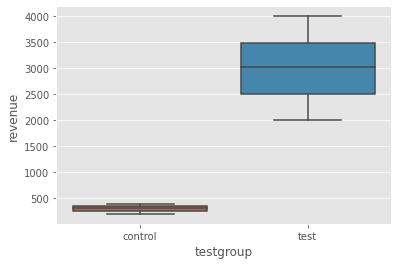

In [54]:
sns.boxplot(x = df_corr_1.testgroup, y = df_corr_1.revenue)

Скорректированный на выбросы датафрейм уже значительно лучше читается на графике.   
На данном боксплоте мы видим существенное различие выручки между групп.   
В контрольной группе выручка на пользователя не превышает 500, среднее/медианное меньше 500, когда в тестовой группе выручка на пользователя находится в диапазоне от 2000 до 4000, среднее/медианное значение чуть выше 3000.   

Отобразим описательные статистики в сводной таблице

In [55]:
df_corr_1.groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
control,1805.0,302.458172,57.914246,200.0,254.0,305.0,352.0,400.0
test,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Исходя из полученных данных, выручка на платящего пользователя в контрольной группе находится в диапазоне от 200 до 400,   
в тестовой группе в диапазоне от 2000 до 4000.   

Вывод: диапазоны в группах не пересекаются, средняя выручка имеет статистическую значимость.   
Т.к. метрика ARPPU является средней выручкой на платящего пользователя, из полученных данных различие данной метрики в группах - на порядок.


Посмотрим на распределения в группах

In [56]:
control = df_corr_1.query('testgroup == "control"')['revenue']

In [57]:
test = df_corr_1.query('testgroup == "test"')['revenue']

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


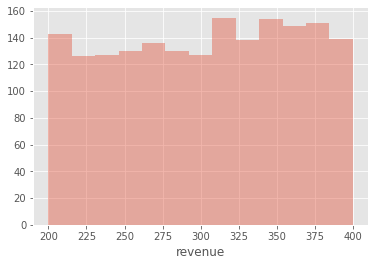

In [58]:
sns.distplot(control, kde=False)

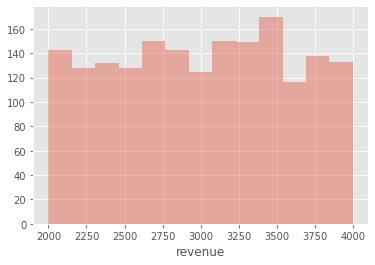

In [59]:
sns.distplot(test, kde=False)

В контрольной и тестовой группах наблюдаем равномерное распределение прибыли на пользователя

В итоге мы получили существенные различия (приблизительно в 10 раз) средней выручки на платящего пользователя в контрольной и тестовой группах.   

Для убедительности, проверим средние значения выручки на пользователя в группах с помощью bootstrap.

Определим функцию бутстрап для проверки средних значений

In [60]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Гистограмма бутстрапа показывает существенные различия средних значений в выборках, распределение разницы средних дает нам предсказуемую картину - в районе -2700, т.к. мы вычитаем из средних контрольной группы бутстраповских выборок средние значения тестовых выборок. Ноль не входит в диапазон, но это и понятно, учитывая что диапазоны выборок даже не пересекаются.

p-value = 0

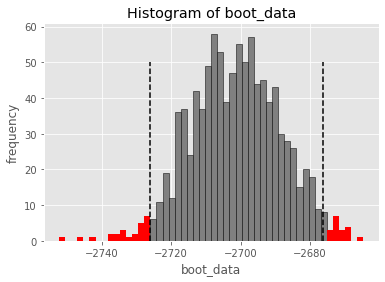

In [61]:
booted_df = get_bootstrap(control, test)

In [62]:
booted_df['p_value']

0.0

Убедившись в существенном различии выручки в группах по основной аудитории, отбросим топ-пользователей из основного датафрейма и пересчитаем метрики.

In [63]:
df_corr = df.query('revenue < 30000')

In [64]:
groups_corr = df_corr.groupby('testgroup', as_index=False).agg({'payment': 'mean', 'revenue': 'mean'})\
    .rename(columns={'payment':'CR', 'revenue':'ARPU'})
groups_corr

,testgroup,CR,ARPU
0,control,0.008937,2.702926
1,test,0.008906,26.751287


In [65]:
groups_2 =  df_corr.groupby('testgroup', as_index=False).agg({'revenue':'sum', 'payment':'sum'})\
    .rename(columns={'payment':'paying_users'})

In [66]:
metrics_corr = groups_2.merge(groups_corr, on = 'testgroup')
metrics_corr

,testgroup,revenue,paying_users,CR,ARPU
0,control,545937,1805,0.008937,2.702926
1,test,5421603,1805,0.008906,26.751287


In [67]:
metrics_corr['ARPPU'] = metrics_corr.revenue / metrics_corr.paying_users
metrics_corr

,testgroup,revenue,paying_users,CR,ARPU,ARPPU
0,control,545937,1805,0.008937,2.702926,302.458172
1,test,5421603,1805,0.008906,26.751287,3003.658172


In [68]:
print('Вывод по сводной таблице:')
print(f'Конверсия практически не изменилась (различие на {round((metrics_corr.CR[0] / metrics_corr.CR[1] - 1)*100, 2)} %)')
print(f'Метрика ARPU увеличилась на {round((metrics_corr.ARPU[1] / metrics_corr.ARPU[0] - 1)*100, 2)} %')
print(f'Метрика ARPPU увеличилась на {round((metrics_corr.ARPPU[1] / metrics_corr.ARPPU[0] - 1)*100, 2)} %')
print(f'В целом, сумма увеличилась на {round((metrics_corr.revenue[1] / metrics_corr.revenue[0] - 1)*100, 2)} %')
print('При этом количество платящих пользователей в группе одинаково')

Вывод по сводной таблице:
Конверсия практически не изменилась (различие на 0.34 %)
Метрика ARPU увеличилась на 889.72 %
Метрика ARPPU увеличилась на 893.08 %
В целом, сумма увеличилась на 893.08 %
При этом количество платящих пользователей в группе одинаково


Итого: выбросы существенно влияют на исследуемые данные. Прежде чем применять статистические критерии, необходимо исследовать причины появления выбросов. В данном случае мы приняли выбросы за выгрузку топ-пользователей в контольную группу, выручка которых значительно выше основной аудитории (89% выручки контрольной группы на 6% пользователей данной группы).   
Избавившись от выбросов, мы заметили существенные различия в стоимостных метриках - различия на порядок.   
В итоге считаем, что наборы акционных предложений в тестовой группе значительно лучше чем в контрольной, пользователи оставляют в 10 раз больше денег.

**Задание 3**   
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

1. Учитывая проведение уникальных событий в игре по времени нам следует обратить внимание на следующие метрики:
 - DAU - дневная аудитория. По данной метрике мы можеи посмотреть динамику количества пользователей, как пользователи реагируют на данное событие.   
 - Retention/Rolling retention - можем посмотреть сколько с нами останется пользователей на время проведения данного события для сравнения метрики без события;   
 - Average Playing Time Per Day - игровое время на одного пользователя в день, предполагаем что игроки будут больше времени проводить в игре;   
 - Frequency by Day - частота входов пользователей в зависимости от времени с их первого визита, можем следить за данной метрикой с целью удержания пользователей;   
  - Average Session Length - средняя продолжительность сессии за интервал проведения события, полезно сравнить с обычным средним значением.   
 Про финансовую составляющую в условии не сказано, лишь о прохождении доп. уровней, поэтому такие метрики как ARPU, ARPPU не рассматриваем.
 
    В целом, если данные метрики идут вверх, можем считать событие успешным. Однако следует заранее предположить на сколько мы хотим увеличить данные метрики.   


2. При усложнении механики событий набор метрик будет тот же самый, добавить можно сюда метрику churn, вероятно будет рост отвалившихся пользователей, и в целом рассматриваемые метрики пойдут вниз.